In [1]:
""" Inflation Prediction Study
Author: Camilla Nore
Date:   2015-08-30
"""
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 5.0)

# NB: As this is iPython, the module will be cached. If you change 
#     the module, you have to restart the iPython kernel.
from inflastudy import InflaData  # Custom module for this study.
from inflastudy import decode_column_name # Decode column name
from inflastudy import NaivePredictions
from inflastudy import error_calculation

                 CPI   PPR_dQ0   PPR_dQ1   PPR_dQ2   PPR_dQ3   PPR_dQ4  \
﻿t                                                                       
2004-03-31 -1.399825       NaN       NaN       NaN       NaN       NaN   
2004-06-30  0.860320       NaN       NaN       NaN       NaN       NaN   
2004-09-30  1.190179       NaN       NaN       NaN       NaN       NaN   
2004-12-31  1.244080       NaN       NaN       NaN       NaN       NaN   
2005-03-31  1.005324       NaN       NaN       NaN       NaN       NaN   
2005-06-30  1.528664       NaN       NaN       NaN       NaN       NaN   
2005-09-30  1.764711       NaN       NaN       NaN       NaN       NaN   
2005-12-31  1.785260       NaN       NaN       NaN       NaN       NaN   
2006-03-31  2.226068       NaN       NaN       NaN       NaN       NaN   
2006-06-30  2.374457  2.350000       NaN       NaN       NaN       NaN   
2006-09-30  2.225729       NaN  1.940000       NaN       NaN       NaN   
2006-12-31  2.500711  2.570000       N

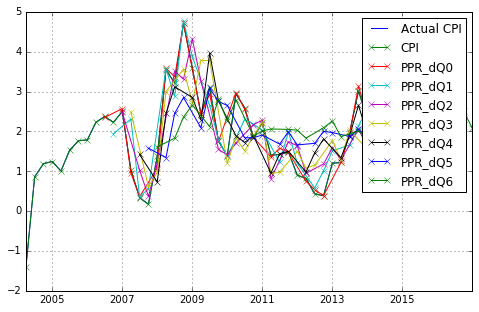

In [2]:
""" Load the data file"""

data = InflaData.InflaData(filename='data/kongepanel_upd_ark_A.csv')
data.remap_to_relative_time(prediction_horizon=16)
data.plot_relative_time_cpi_data()
#print data.raw_data.CPI       # Uncomment this line to see raw CPI data.
#print data.raw_data.columns   # Uncomment this line to see column names.
print(data.cpi_pred_relative)

In [3]:
# Calculate naive values and error
actual_cpi = data.raw_data['CPI']
naive = NaivePredictions.NaivePredictions(actual_cpi)
naive_error = error_calculation.PredictionError(naive.data)

pred error std PPR_dQ0_err     0.081003
PPR_dQ1_err     0.162007
PPR_dQ2_err     0.243010
PPR_dQ3_err     0.324013
PPR_dQ4_err     0.405017
PPR_dQ5_err     0.486020
PPR_dQ6_err     0.567024
PPR_dQ7_err     0.648027
PPR_dQ8_err     0.729030
PPR_dQ9_err     0.810034
PPR_dQ10_err    0.891037
PPR_dQ11_err    0.972040
PPR_dQ12_err    1.053044
PPR_dQ13_err    1.134047
PPR_dQ14_err    1.215050
PPR_dQ15_err    1.296054
dtype: float64


In [4]:
# Calculate cpi error
cpi_error = error_calculation.PredictionError(data.cpi_pred_relative)

pred error std PPR_dQ0_err     0.094326
PPR_dQ1_err     0.412671
PPR_dQ2_err     0.601192
PPR_dQ3_err     0.750038
PPR_dQ4_err     0.722060
PPR_dQ5_err     1.004422
PPR_dQ6_err     1.002497
PPR_dQ7_err     1.042570
PPR_dQ8_err     0.876825
PPR_dQ9_err     1.002241
PPR_dQ10_err    0.862679
PPR_dQ11_err    0.617426
PPR_dQ12_err    0.862248
PPR_dQ13_err    0.761941
PPR_dQ14_err    0.742472
PPR_dQ15_err    0.620416
dtype: float64


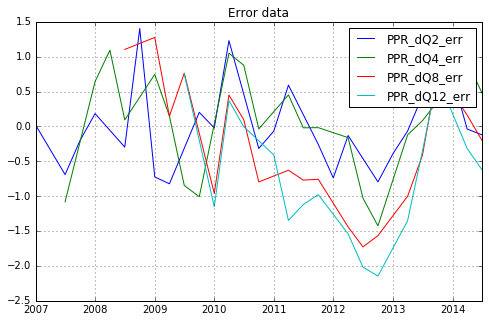

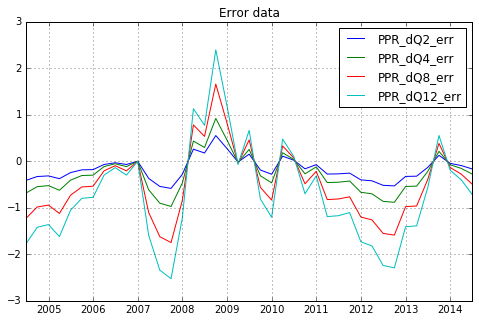

In [5]:
# Plot and compare with naive.
cpi_error.plot_selected()
naive_error.plot_selected()

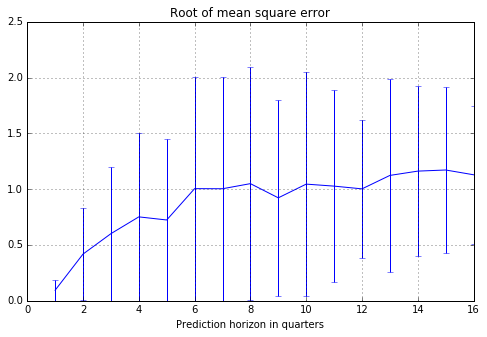

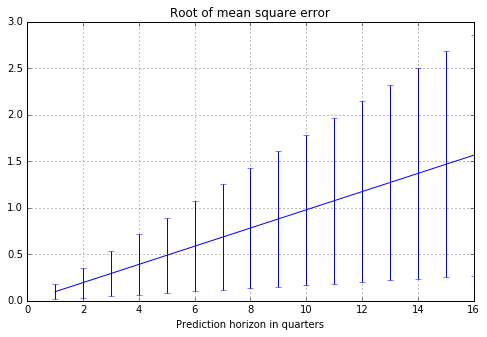

In [6]:
# Plot and compare with naive.
cpi_error.plot_rms()
naive_error.plot_rms()

In [ ]:
# Export the data to csv.
data.cpi_pred_error.to_excel('pred_error.xlsx')

In [ ]:
""" Plot all CPI predictions and the actual CPI. """

plt.figure('CPI predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI predictions')
plt.xlabel('Year')
# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI'],
         label ='CPI')

for col_name in data.cpi_predictions:
    plt.plot(data.cpi_predictions.index,
             data.cpi_predictions[col_name],
             '--',
             label = 'col_name')

In [ ]:
""" Plot all CPI-jae predictions and the actual CPI-jae. """

plt.figure('CPI jae predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI jae predictions')
plt.xlabel('Year')

# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI-jae'],
         label ='CPI jae')

for col_name in data.cpi_jae_predictions:
    plt.plot(data.cpi_jae_predictions.index,
             data.cpi_jae_predictions[col_name],
             '--',
             label = 'col_name')
